In [1]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

dataset_train = pd.read_csv('retail_syn_hackathon_phase1.csv')
# dataset_train = dataset_train.dropna(axis='columns')
dataset_train = dataset_train.dropna()
dataset_train = dataset_train.astype('float32')
corr = dataset_train.corrwith(dataset_train['relative_margin_with_supplier_binary_positive'])
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

Text(0.5, 1.0, 'Negative (0) vs. Positive (1)')

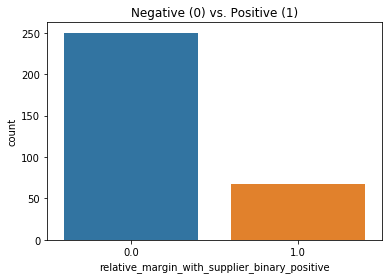

In [2]:
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial import distance

# taking a closer look at the class variable
sns.countplot('relative_margin_with_supplier_binary_positive', data = dataset_train)
plt.title('Negative (0) vs. Positive (1)')


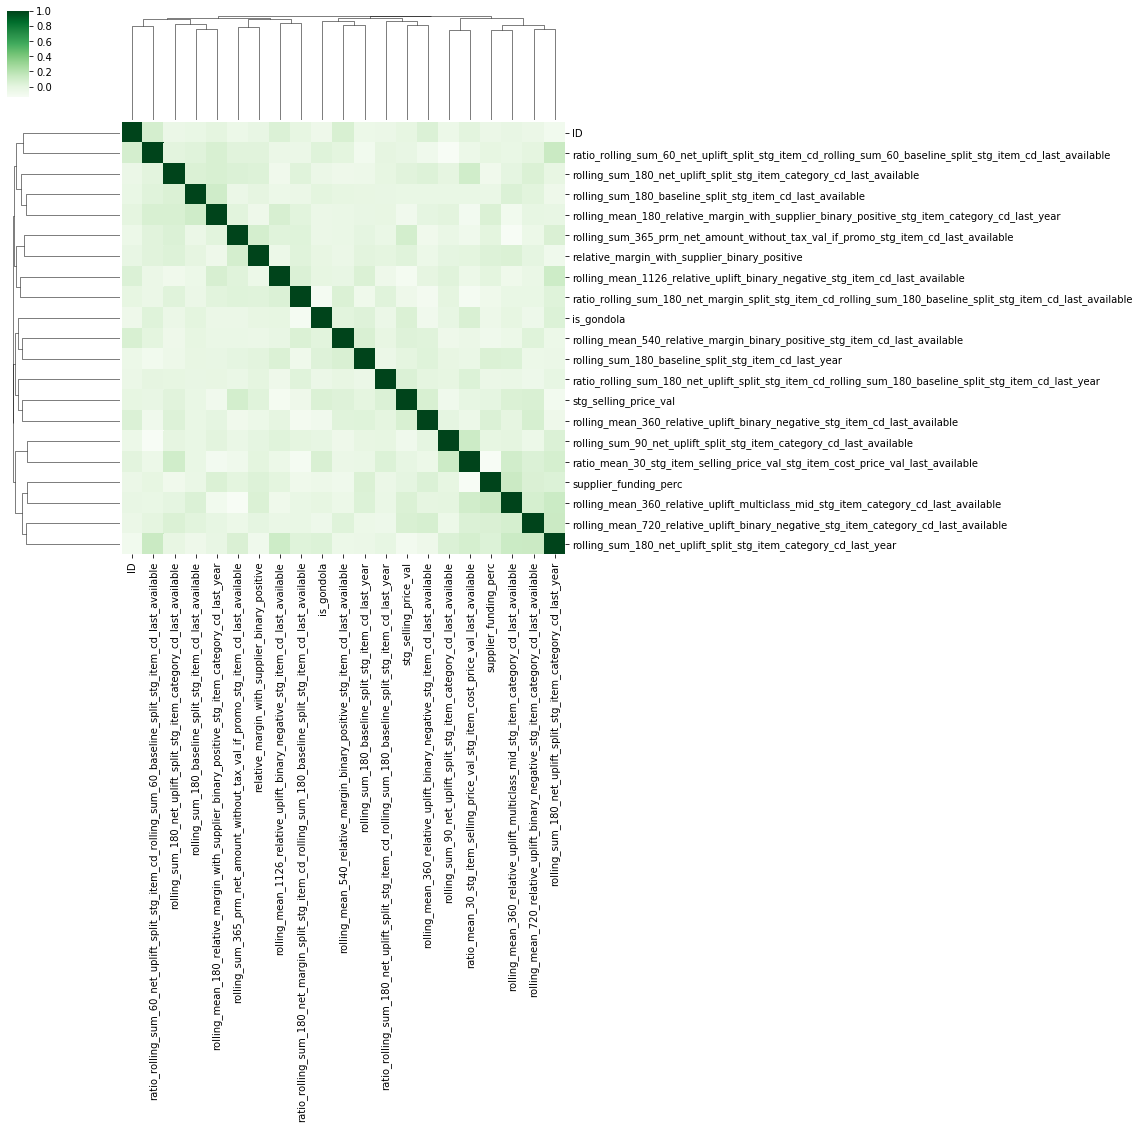

In [3]:
corr_matrix = dataset_train.corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,row_cluster=True,col_cluster=True,figsize=(10,10),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

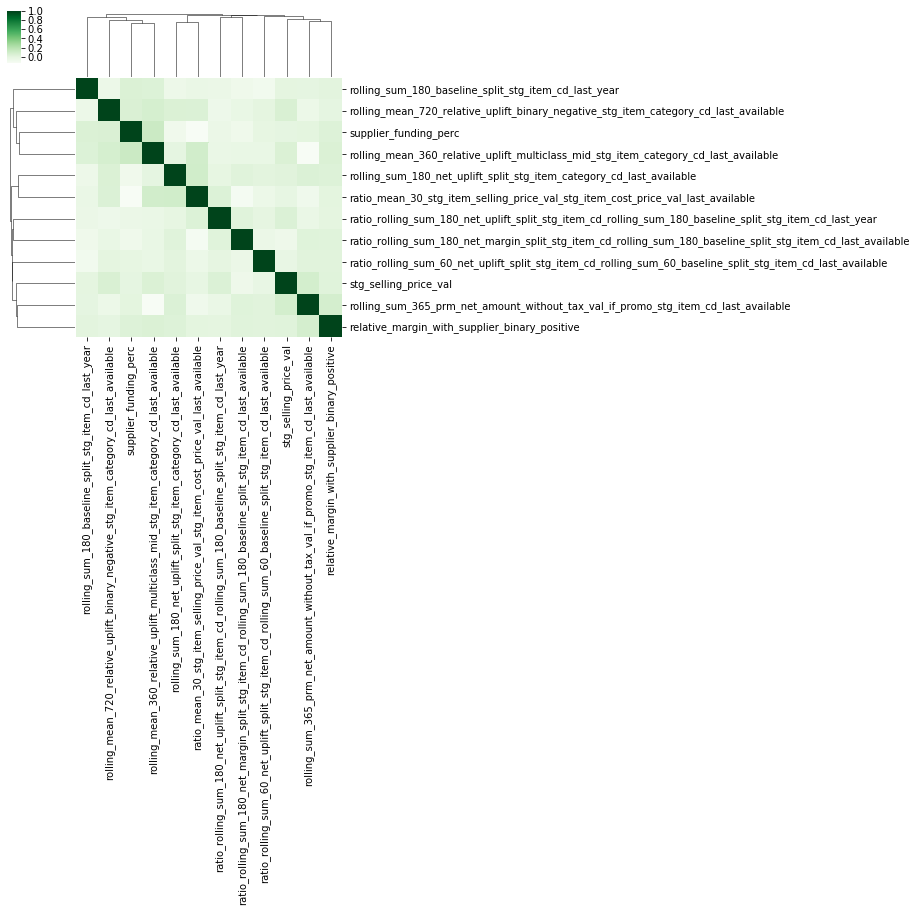

Correlation Strength:
relative_margin_with_supplier_binary_positive    1.0
dtype: float64


In [4]:
correlated_features = corr[corr>0.003].index.tolist()
corr_matrix = dataset_train[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength:")
print(corr[corr>0.1].sort_values(ascending=False))

[0]	validation_0-error:0.159763	validation_0-rmse:0.493279	validation_1-error:0.261868	validation_1-rmse:0.495187
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-error:0.1762	validation_0-rmse:0.48764	validation_1-error:0.232772	validation_1-rmse:0.490255
[2]	validation_0-error:0.176857	validation_0-rmse:0.481879	validation_1-error:0.209801	validation_1-rmse:0.485394
[3]	validation_0-error:0.179487	validation_0-rmse:0.476039	validation_1-error:0.212864	validation_1-rmse:0.481576
[4]	validation_0-error:0.184089	validation_0-rmse:0.471059	validation_1-error:0.209801	validation_1-rmse:0.477202
[5]	validation_0-error:0.185404	validation_0-rmse:0.466344	validation_1-error:0.209801	validation_1-rmse:0.473174
[6]	validation_0-error:0.188692	validation_0-rmse:0.461581	validation_1-error:0.209801	validation_1-rmse:0.469499
[7]	validation_0-error:0.193294	validation_0-r

[71]	validation_0-error:0.145299	validation_0-rmse:0.30659	validation_1-error:0.206738	validation_1-rmse:0.406162
[72]	validation_0-error:0.143327	validation_0-rmse:0.305644	validation_1-error:0.20827	validation_1-rmse:0.406108
[73]	validation_0-error:0.140039	validation_0-rmse:0.303997	validation_1-error:0.20827	validation_1-rmse:0.406128
[74]	validation_0-error:0.140039	validation_0-rmse:0.303034	validation_1-error:0.20827	validation_1-rmse:0.406
[75]	validation_0-error:0.139382	validation_0-rmse:0.302282	validation_1-error:0.20827	validation_1-rmse:0.405975
[76]	validation_0-error:0.140039	validation_0-rmse:0.301171	validation_1-error:0.206738	validation_1-rmse:0.40573
[77]	validation_0-error:0.139382	validation_0-rmse:0.300218	validation_1-error:0.206738	validation_1-rmse:0.405781
[78]	validation_0-error:0.138067	validation_0-rmse:0.298135	validation_1-error:0.206738	validation_1-rmse:0.405965
[79]	validation_0-error:0.136095	validation_0-rmse:0.297035	validation_1-error:0.20827	va

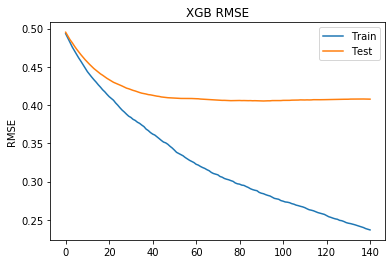

In [7]:
import xgboost as xgb
from sklearn.datasets import dump_svmlight_file
from sklearn.model_selection  import train_test_split

# values = dataset_train.values
# train = values[:1500, :]
# val = values[1500:1600, :]
# test = values[1600:, :]
# train_x, train_y = train[:, :-1], train[:, -1]
# val_x, val_y = val[:, :-1], val[:, -1]
# test_x, test_y = test[:, :-1], test[:, -1]

dataset_train = pd.read_csv('retail_syn_hackathon_phase1.csv')
# dataset_train = dataset_train.dropna(axis='columns')
dataset_train = dataset_train[correlated_features]
dataset_train = dataset_train.fillna(0)

X = dataset_train.iloc[:, :-1]
Y = dataset_train.iloc[:, -1]

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=0)



# from imblearn.over_sampling import SMOTE

# # applying SMOTE to our data and checking the class counts
# X_resampled, y_resampled = SMOTE().fit_resample(train_X, train_Y)


model = xgb.XGBClassifier(max_depth=8, min_child_weight=0.26, subsample=0.9 ,gamma = 0.1, colsample_bytree=0.8, objective='binary:logistic',n_estimators=100000,learning_rate = 0.03)
eval_set = [(train_X, train_Y), (test_X, test_Y)]

model.fit(train_X, train_Y, early_stopping_rounds = 50, eval_metric=["error", "rmse"], eval_set=eval_set, verbose=1)

results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGB RMSE')
plt.show()

In [8]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(test_X)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_Y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.33%


In [9]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_X,train_Y)

y_pred=clf.predict(test_X)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_Y, y_pred))

Accuracy: 0.7917304747320061


In [10]:
# Grid search

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

# A parameter grid for XGBoost
params = {
        'learning_rate': np.linspace(0,1,num=101),
        'min_child_weight': np.linspace(0,1,num=101),
        'gamma': np.linspace(0,5,num=101),
        'subsample': np.linspace(0,1,num=11),
        'colsample_bytree': np.linspace(0,1,num=11),
        'max_depth': [1,2,3,4,5,6,7,8,9,10]
        }

xgb = XGBClassifier(n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

folds = 10
param_comb = 10 

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_resampled,y_resampled), verbose=3, random_state=1001 )

random_search.fit(X_resampled, y_resampled)

print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   58.2s finished



 All results:
{'mean_fit_time': array([0.49390588, 1.56811838, 1.01023085, 3.4633378 , 1.15645239,
       3.07545991, 3.6329432 , 1.54573033, 1.80172782, 2.37932832]), 'std_fit_time': array([0.03206506, 0.06804701, 0.03577367, 0.09840382, 0.05179998,
       0.06344066, 0.07556893, 0.04471893, 0.0359355 , 0.10191432]), 'mean_score_time': array([0.00346992, 0.00529618, 0.00725486, 0.00703921, 0.00544693,
       0.00890429, 0.01144598, 0.00757272, 0.00868187, 0.01495051]), 'std_score_time': array([0.0014512 , 0.00179805, 0.00261348, 0.001001  , 0.00082073,
       0.00230254, 0.00235518, 0.002015  , 0.00305351, 0.00282833]), 'param_subsample': masked_array(data=[0.0, 0.9, 0.6000000000000001, 0.7000000000000001, 0.8,
                   0.5, 0.30000000000000004, 0.9, 0.4, 0.2],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[0.9, 0.07, 0

In [11]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_X,train_Y)

y_pred=clf.predict(test_X)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_Y, y_pred))

Accuracy: 0.7901990811638591


In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(train_X,train_Y)
y_pred = svclassifier.predict(test_X)

print("Accuracy:",metrics.accuracy_score(test_Y, y_pred))